In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras as keras
from keras import models, layers

# Definition of a custom loss function
When you define a custom loss function or a custom OBJECT you have to register them so that you can SAVE and LOAD the model (keras tryes to save as lightweight infos as possible)

Add @keras.saving.register_keras_serializable decorator

tf.Tensor(0.008334999999999999, shape=(), dtype=float64)


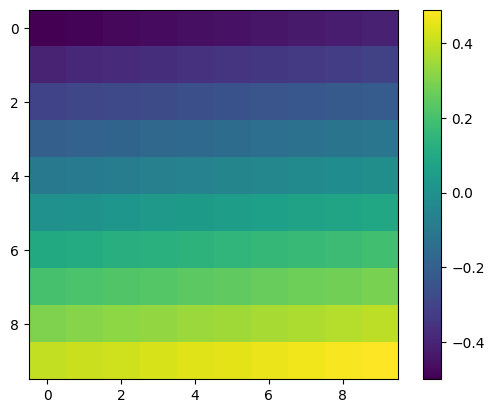

In [ ]:
t1 = tf.range(10*10) / 100 - 0.5
t1 = tf.reshape(t1, [10,10])
t2 = tf.zeros([10,10], dtype=tf.double)

plt.imshow(t1)
plt.colorbar()

# Definition of a custom Loss function in keras
@keras.saving.register_keras_serializable 
def custom_loss(y_true, y_pred):
    difference =  tf.math.squared_difference(y_true, y_pred)
    loss = tf.math.reduce_mean(difference) / 10
    return loss

loss = custom_loss(t1, t2)

print(loss)

In [15]:
# Create base model
def create_model(input_shape):
    inputs = keras.Input(input_shape)
    x = layers.Flatten() (inputs)

    x = layers.Dense(64, activation='relu') (x)
    output = layers.Dense(1, activation='relu') (x)

    return keras.Model(inputs=inputs, outputs=output)

model = create_model((10,10))
model.summary()
keras.utils.plot_model(model)

model.compile(loss=custom_loss, optimizer='adam')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

# Custom loss with single external parameter
In this cell I explore how to add a custom loss with external parameters given to the function

In [17]:
# Define custom loss with a wrapper
def wrapper_custom_loss(param):
    def custom_loss(y_true, y_pred):
        diff = tf.math.squared_difference(y_true, y_pred)
        loss = tf.math.reduce_mean(diff)
        loss = loss / param
        return loss
    return custom_loss

loss_param = wrapper_custom_loss(10)

# Custom loss with othe quantities to minimize
Example:

$$\sum_{i=0}^{N}
\left( y_i -  \sum_{j=0}^{M} x_{i,j} W_j \right)^2
+\lambda \sum_{j=0}^{M} |W_j| $$

In this case the loss is added to the layer through \textbf{add_loss()}

In [19]:
from keras.layers import Layer
from tensorflow.math import reduce_sum, square

class MyActivityRegularizer(Layer):

    def __init__(self, rate=1e-2):
        super(MyActivityRegularizer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # adds to the global loss the following quantity:
        self.add_loss(self.rate * reduce_sum(square(inputs)))
        return inputs
    
# Custom Layer/Model of the MLP WITH that add in the loss
class SparseMLP(Layer):
  """Stack of Linear layers with our custom regularization loss."""

  def __init__(self, output_dim):
      super(SparseMLP, self).__init__()
      self.dense_1 = layers.Dense(32, activation=tf.nn.relu)
      self.regularization = MyActivityRegularizer(1e-2)
      self.dense_2 = layers.Dense(output_dim)

  def call(self, inputs):
      x = self.dense_1(inputs)
      x = self.regularization(x)
      return self.dense_2(x)

# Call the layer
mlp = SparseMLP(1)
y = mlp(np.random.normal(size=(10, 10)))

print(mlp.losses)  # List containing one float32 scalar

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6241376399993896>]


# Loss function for PRESSURE net
Build field and test loss function.

The loss function "works". Now it is time to apply it to the model

tf.Tensor(2803.0303, shape=(), dtype=float32)


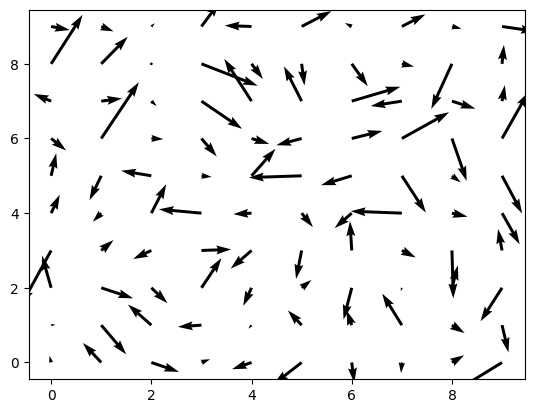

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Laplacian filter
L = tf.constant(
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=tf.float32)
L = tf.reshape(L, [3,3,1,1])

# Definition of the LOSS
def f_obj(rho, W):
    def loss(div_u, p_t):
        # laplacian of pressure
        lap_p = tf.nn.convolution(p_t, L, padding="SAME")

        # Computing objective
        diff = tf.math.squared_difference(div_u, 1/rho * lap_p)
        obj = tf.math.reduce_sum(tf.math.multiply(W, diff))
        return obj
    return loss

# Define a tensor field
u_t = tf.random.normal(shape=(10,10))
u_t = tf.reshape(u_t, [1,10,10,1])
v_t = tf.random.normal(shape=(10,10))
v_t = tf.reshape(v_t, [1,10,10,1])
p_t = tf.random.normal(shape=(10,10))
p_t = tf.reshape(p_t, [1,10,10,1])

# Compute derivative (row-column order)
D_x = tf.constant(
    [[0., -1., 0.],
     [0., 0., 0.],
     [0., 1., 0.]]
)
D_x = tf.reshape(D_x, [3,3,1,1])
D_y = tf.constant(
    [[0., 0., 0.],
     [-1., 0., 1.],
     [0., 0., 0.]]
)
D_y = tf.reshape(D_y, [3,3,1,1])

# Divergence of velocity field
u_x = tf.nn.convolution(u_t, D_x, padding="SAME")
u_y = tf.nn.convolution(u_t, D_y, padding="SAME")
div_u = u_x + u_y

# Instantiate loss function
loss = f_obj(1,1)
plt.quiver(u_t[0,:,:,0], v_t[0,:,:,0])
print(loss(div_u, p_t))

